<a href="https://colab.research.google.com/github/EmanuelAlogna/MRI-generation/blob/master/src/prediction_and_prediction_normalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math

print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

2.0.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading train, validation and test sets

In [0]:
def get_feature_description(modalities):                                                   
                                                                                           
    feature_description =lambda mod : {                                                    
                            mod+'_mri': tf.io.FixedLenFeature([], tf.string),              
                            mod+'_path': tf.io.FixedLenFeature([], tf.string),             
                                                                                           
                            mod+'_mri_min': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_min_src': tf.io.FixedLenFeature([], tf.float32),     
                            mod+'_mri_max': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_max_src': tf.io.FixedLenFeature([], tf.float32),     
                                                                                           
                            mod+'_mri_lperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_mri_lperc_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_x_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_y_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_x_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_y_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                                                                                           
                            mod+'_x_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_y_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_z_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                                                                                           
                            mod+'_z_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_x_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_y_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_patient': tf.io.FixedLenFeature([], tf.string),          
                            mod+'_sample_number': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_grade': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_location': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_version': tf.io.FixedLenFeature([], tf.string),  
                            mod+'_dataset_name': tf.io.FixedLenFeature([], tf.string),     
                            mod+'_mri_type': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_split': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_mri_seq': tf.io.FixedLenFeature([], tf.string),  
                          }                                                                
    features = {}                                                                          
    for mod in modalities:
        features.update(feature_description(mod))
    return features

In [0]:
#BUFFER_SIZE = 400
BATCH_SIZE = 32

In [0]:
use_gzip_compression = True

def load_dataset(name, mri_type, center_crop=None, random_crop=None, filter=None, batch_size=BATCH_SIZE, cache=True, 
                 prefetch_buffer=1, shuffle_buffer=128, interleave=1, cast_to=tf.float32, clip_labels_to=0.0, 
                 take_only=None, shuffle=True, infinite=False, n_threads=os.cpu_count()):
    def parse_sample(sample_proto):
        parsed = tf.io.parse_single_example(sample_proto, get_feature_description(["OT"]+mri_type))
        # Decoding image arrays
        
        slice_shape = [parsed['OT_x_dimension'.format(mri_type[0])], parsed['OT_y_dimension'], 1]
        # Decoding the ground truth
        parsed['seg'] = tf.cast(tf.reshape(tf.io.decode_raw(parsed['OT_mri'], tf.float32), shape=slice_shape), dtype=cast_to)
        # Decode each channel and stack in a 3d volume
        stacked_mri = list()
        for mod in mri_type:
            stacked_mri.append(tf.cast(tf.reshape(tf.io.decode_raw(parsed['{}_mri'.format(mod)], tf.float32), shape=slice_shape), dtype=cast_to))
        parsed['mri'] = tf.concat(stacked_mri, axis=-1)
        # Clipping the labels if requested
        parsed['seg'] = tf.clip_by_value(parsed['seg'], 0.0, clip_labels_to) if clip_labels_to else parsed['seg']
        
        # Cropping
        if random_crop or center_crop:
            # Stacking the mri and the label to align the crop shape
            mri_seg = tf.concat([parsed['mri'], parsed['seg']], axis=-1)
            if random_crop:
                random_crop[-1] = mri_seg.shape[-1] 
                cropped = tf.image.random_crop(mri_seg, size=random_crop)
            else:
                cropped = tf.image.resize_with_crop_or_pad(mri_seg,center_crop[0],center_crop[1])
            # Splitting back
            parsed['mri'] = cropped[:,:,:len(mri_type)]
            parsed['seg'] = cropped[:,:,len(mri_type):]
        
        return parsed
    
    path = './drive/My Drive/MRI-generation/{}.tfrecords'.format(name)
    dataset = tf.data.TFRecordDataset(path, compression_type='GZIP' if use_gzip_compression else "")
    dataset = dataset.filter(filter) if filter is not None else dataset
    dataset = dataset.take(take_only) if take_only is not None else dataset

    # You should generally cache after loading and preprocessing the data, 
    # but before shuffling, repeating, batching and prefetching”
    dataset = dataset.cache() if cache else dataset
    if shuffle and infinite:
        dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(shuffle_buffer))
    else:
        dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True) if shuffle else dataset
        dataset = dataset.repeat() if infinite else dataset
    dataset = dataset.map(parse_sample, num_parallel_calls=None)
    dataset = dataset.batch(batch_size) if batch_size > 0 else dataset
    
    

    if interleave > 1:
        dataset = dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(interleave), cycle_length=n_threads, block_length=interleave, num_parallel_calls=n_threads)
  
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
# loading all the dataset, with only modality T1 and T2
# I'll focus now on synthesizing T2 from T1

def load_datasets():
    validation = load_dataset('brats2015_validation_crop_mri', ['MR_T1', 'MR_T2'])
    training = load_dataset('brats2015_training_crop_mri', ['MR_T1', 'MR_T2'])
    testing = load_dataset('brats2015_testing_crop_mri', ['MR_T1', 'MR_T2'])
    return training, validation , testing

In [0]:
training, validation, testing = load_datasets() # I'll use this in case I get stuck with the cache.

In [0]:
# PROCESSING IMAGES IN THE BATCH
def process_batch(batch):   # takes in input a raw_record[mod].numpy()
    batch = tf.io.decode_raw(batch, tf.float32)
    batch = tf.reshape(batch, (BATCH_SIZE, 180, 180))
    paddings = tf.constant([[0, 0], [38, 38], [38, 38]])
    batch = tf.pad(batch, paddings, "CONSTANT")
    batch = tf.expand_dims(batch, axis=3)
    return batch
    
# final shape will be (bs, 256, 256, 1): now the batch is ready to be fed to the GAN

In [0]:
# this function preprocesses the input image and the ground truth from a raw_record
# images in the return are then ready to be fed into the GAN
def take_images_from_raw(raw_record):

    inp, ground_truth = raw_record[modalities[0]], raw_record[modalities[1]]
    inp = process_batch(inp)
    ground_truth = process_batch(ground_truth)
    return inp, ground_truth

(32, 256, 256, 1) (32, 256, 256, 1)
Batch with a size of 32 and dimension of (256,256) per image


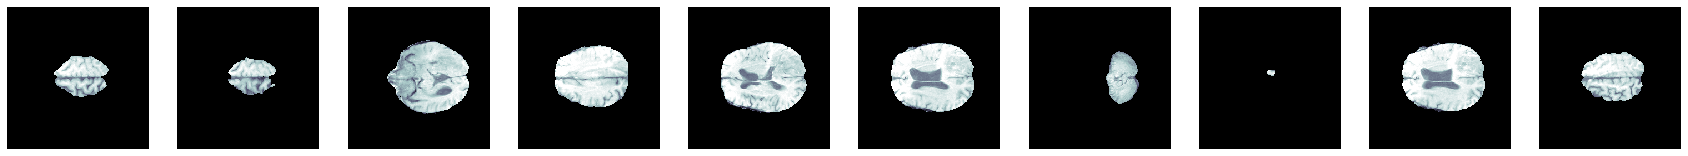

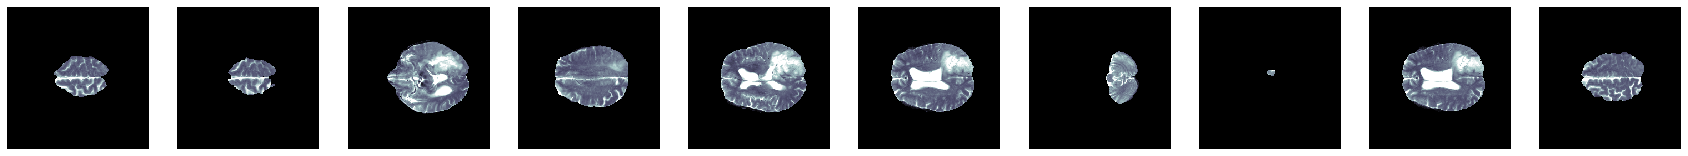

In [10]:
modalities = ['MR_T1_mri', 'MR_T2_mri']

for raw_record in validation.take(1):
    inp, ground_truth = take_images_from_raw(raw_record)

    print(inp.shape, ground_truth.shape)

    plt.figure(1 , figsize = (30, 20))
    print("Batch with a size of {} and dimension of (256,256) per image".format(BATCH_SIZE))
    n = 0 
    for i in range(10):     # batch size is different from 10, but let's show just 10 images 
    # to see all the images belonging to the batch, just change 10 with 'BATCH_SIZE'
        n += 1
        plt.subplot(2 , 10 , n)
        img = inp[i]
        plt.imshow(tf.squeeze(img), cmap='bone')
        plt.axis('off')

    n = 0 
    plt.figure(2 , figsize = (30, 20))
    for i in range(10):    
        n += 1
        plt.subplot(2 , 10 , n)
        img = ground_truth[i]
        plt.imshow(tf.squeeze(img), cmap='bone')
        plt.axis('off')

## Load some useful functions


In [0]:
def rescale(x, xmin, xmax, a, b):
    return (a + (b-a)*(x-xmin)/(xmax-xmin))  
    # to rescale in the range [0, 1], 'a' must be 0 and 'b' = 1

In [0]:
@tf.function
def normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = rescale(image[i], min_value, max_value, 0, 1)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized

In [0]:
def resize_with_crop(image_input, image_ground_truth, image_prediction):
    # FROM THE PAPER: 
    # "In order to crop out the brain region from each sequence, we calculate the largest bounding box that 
    # can accommodate each brain in the whole dataset, and then use the coordinates to crop each sequence in every patient scan. 
    # The final cropped size of a single patient scan with all sequences contains 148 axial slices of size 194 × 155."

    # I use this size in order to have similar results to the ones reached by the paper.

    image_input = tf.image.resize_with_crop_or_pad(image_input, 155, 194)
    image_ground_truth = tf.image.resize_with_crop_or_pad(image_ground_truth, 155, 194)
    image_prediction = tf.image.resize_with_crop_or_pad(image_prediction, 155, 194)

    return image_input, image_ground_truth, image_prediction

In [0]:
def generate_images(model, test_input, tar, train):
    
    # FROM STACKOVERFLOW:
    # Some neural network layers behave differently during training and inference, for example Dropout and BatchNorm
    # During training, dropout will randomly drop out units and correspondingly scale up activations of the remaining units.
    # During inference (training=false) it does nothing (since you usually don't want the randomness of dropping out units here).
    # The training argument lets the layer know which of the two "paths" it should take. 
    # If you set this incorrectly, your network might not behave as expected.
    
    prediction = model(test_input, training=train)
    
    print("1st sample from the batch. Dimension of (256,256) per image".format(BATCH_SIZE))
    
    display_list = [test_input, tar, prediction]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    plt.figure(1 , figsize = (12 , 12))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(tf.squeeze(display_list[i][0]), cmap='bone') # [0] = I'm showing only the 1st sample
        plt.axis('off')
    plt.show()
    return prediction


In [0]:
def plot_images(inp, ground_truth, prediction):
    display_list = [inp, ground_truth, prediction]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    plt.figure(1 , figsize = (16 , 8))
    n = 0
    for i in range(3):
        for j in range(5):  # batch size is different from 10, but let's show just 10 images.
            n += 1
            plt.subplot(3, 5, n).title.set_text(title[i])
            plt.imshow(tf.squeeze(display_list[i][j]), cmap='bone')
            plt.axis('off')
    plt.show()
    print()

In [0]:
def evaluate_GAN(model, dataset, set_type):
    num_batches = 0                 # CAREFUL when batch_size is modified!!!
    if set_type == 'test':
        num_batches = 112           # in the test set, with batch 32, there are 112 elements.
    elif set_type == 'validation':
        num_batches = 108
    elif set_type == 'train':
        num_batches = 876
    container_psnr = tf.TensorArray(tf.float32, size=num_batches)     
    container_mse = tf.TensorArray(tf.float32, size=num_batches)
    container_ssim = tf.TensorArray(tf.float32, size=num_batches)
    for idx, raw_record in dataset.enumerate():
        
        inp, ground_truth = take_images_from_raw(raw_record)

        # generate the prediction        
        prediction = model(inp, training=False)

        # crop the images
        inp_cr, ground_truth_cr, prediction_cr = resize_with_crop(inp, ground_truth, prediction)
        if idx == 0:
            prediction = plot_images(inp_cr, ground_truth_cr, prediction_cr)
        
        # normalize the prediction
        prediction_normalized_cr = normalize(prediction_cr)

        # compute the metrics of similarity
        mean, std, psnr = compute_psnr(ground_truth_cr, prediction_normalized_cr)
        container_psnr = container_psnr.write(idx, psnr)

        mean, std, mse = compute_mse(ground_truth_cr, prediction_normalized_cr)
        container_mse = container_mse.write(idx, mse)

        mean, std, ssim = compute_ssim(ground_truth_cr, prediction_normalized_cr)
        container_ssim = container_ssim.write(idx, ssim)

    container_psnr = container_psnr.stack()
    container_mse = container_mse.stack()
    container_ssim = container_ssim.stack()
    mean_psnr = tf.reduce_mean(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    std_psnr = tf.math.reduce_std(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    mean_mse = tf.reduce_mean(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    std_mse = tf.math.reduce_std(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    mean_ssim = tf.reduce_mean(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))
    std_ssim = tf.math.reduce_std(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))

    print("PSNR on {} set: {} ± {}".format(set_type, (f'{mean_psnr:.4f}'), (f'{std_psnr:.4f}')))
    print("MSE on {} set: {} ± {}".format(set_type, (f'{mean_mse:.4f}'), (f'{std_mse:.4f}')))
    print("SSIM on {} set: {} ± {}".format(set_type, (f'{mean_ssim:.4f}'), (f'{std_ssim:.4f}')))

    return mean_psnr, mean_mse, mean_ssim

In [0]:
def evaluate_GAN2(model, dataset, set_type):
    num_batches = 0                 # CAREFUL when batch_size is modified!!!
    if set_type == 'test':
        num_batches = 112           # in the test set, with batch 32, there are 112 elements.
    elif set_type == 'validation':
        num_batches = 108
    elif set_type == 'train':
        num_batches = 876
    container_psnr = tf.TensorArray(tf.float32, size=num_batches)     
    container_mse = tf.TensorArray(tf.float32, size=num_batches)
    container_ssim = tf.TensorArray(tf.float32, size=num_batches)
    container_psnr_norm = tf.TensorArray(tf.float32, size=num_batches)     
    container_mse_norm = tf.TensorArray(tf.float32, size=num_batches)
    container_ssim_norm = tf.TensorArray(tf.float32, size=num_batches)
    for idx, raw_record in dataset.enumerate():
        
        inp, ground_truth = take_images_from_raw(raw_record)

        # generate the prediction        
        prediction = model(inp, training=False)

        # crop the images
        inp_cr, ground_truth_cr, prediction_cr = resize_with_crop(inp, ground_truth, prediction)
        if idx == 0:
            prediction = plot_images(inp_cr, ground_truth_cr, prediction_cr)
        
        # normalize the prediction
        prediction_normalized_cr = normalize(prediction_cr)

        # compute the metrics of similarity
        mean, std, psnr = compute_psnr(ground_truth_cr, prediction_normalized_cr)
        container_psnr_norm = container_psnr_norm.write(idx, psnr)

        mean, std, mse = compute_mse(ground_truth_cr, prediction_normalized_cr)
        container_mse_norm = container_mse_norm.write(idx, mse)

        mean, std, ssim = compute_ssim(ground_truth_cr, prediction_normalized_cr)
        container_ssim_norm = container_ssim_norm.write(idx, ssim)

        mean, std, psnr = compute_psnr(ground_truth_cr, prediction_cr)
        container_psnr = container_psnr.write(idx, psnr)

        mean, std, mse = compute_mse(ground_truth_cr, prediction_cr)
        container_mse = container_mse.write(idx, mse)

        mean, std, ssim = compute_ssim(ground_truth_cr, prediction_cr)
        container_ssim = container_ssim.write(idx, ssim)

    container_psnr = container_psnr.stack()
    container_mse = container_mse.stack()
    container_ssim = container_ssim.stack()
    container_psnr_norm = container_psnr_norm.stack()
    container_mse_norm = container_mse_norm.stack()
    container_ssim_norm = container_ssim_norm.stack()

    mean_psnr = tf.reduce_mean(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    std_psnr = tf.math.reduce_std(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    mean_mse = tf.reduce_mean(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    std_mse = tf.math.reduce_std(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    mean_ssim = tf.reduce_mean(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))
    std_ssim = tf.math.reduce_std(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))
    
    mean_psnr_norm = tf.reduce_mean(tf.boolean_mask((container_psnr_norm), tf.math.is_finite(container_psnr_norm)))
    std_psnr_norm = tf.math.reduce_std(tf.boolean_mask((container_psnr_norm), tf.math.is_finite(container_psnr_norm)))
    mean_mse_norm = tf.reduce_mean(tf.boolean_mask((container_mse_norm), tf.math.is_finite(container_mse_norm)))
    std_mse_norm = tf.math.reduce_std(tf.boolean_mask((container_mse_norm), tf.math.is_finite(container_mse_norm)))
    mean_ssim_norm = tf.reduce_mean(tf.boolean_mask((container_ssim_norm), tf.math.is_finite(container_ssim_norm)))
    std_ssim_norm = tf.math.reduce_std(tf.boolean_mask((container_ssim_norm), tf.math.is_finite(container_ssim_norm)))
    

    print("PSNR on {} set: {} ± {}".format(set_type, (f'{mean_psnr:.4f}'), (f'{std_psnr:.4f}')))
    print("PSNR norm on {} set: {} ± {}".format(set_type, (f'{mean_psnr_norm:.4f}'), (f'{std_psnr_norm:.4f}')))
    print()
    print("MSE on {} set: {} ± {}".format(set_type, (f'{mean_mse:.4f}'), (f'{std_mse:.4f}')))
    print("MSE norm on {} set: {} ± {}".format(set_type, (f'{mean_mse_norm:.4f}'), (f'{std_mse_norm:.4f}')))
    print()
    print("SSIM on {} set: {} ± {}".format(set_type, (f'{mean_ssim:.4f}'), (f'{std_ssim:.4f}')))
    print("SSIM norm on {} set: {} ± {}".format(set_type, (f'{mean_ssim_norm:.4f}'), (f'{std_ssim_norm:.4f}')))

    return mean_psnr, mean_mse, mean_ssim, mean_psnr_norm, mean_mse_norm, mean_ssim_norm

In [0]:
def plot_metrics(psnr, mse, ssim, psnr_norm, mse_norm, ssim_norm):
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    f.subplots_adjust(hspace=0.4)

    max_epoch = psnr.shape[0]

    epoch_list = list(range(1,max_epoch+1))
    ax1.plot(epoch_list, psnr, label='Val PSNR')
    ax1.plot(epoch_list, psnr_norm, label='Val PSNR norm')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('PSNR Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('PSNR')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, mse, label='Val MSE')
    ax2.plot(epoch_list, mse_norm, label='Val MSE norm')
    ax2.set_xticks(np.arange(1, max_epoch, 5))
    ax2.set_ylabel('MSE Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('MSE')
    l2 = ax2.legend(loc="best")

    ax3.plot(epoch_list, ssim, label='Val SSIM')
    ax3.plot(epoch_list, ssim_norm, label='Val SSIM norm')
    ax3.set_xticks(np.arange(1, max_epoch, 5))
    ax3.set_ylabel('SSIM Value')
    ax3.set_xlabel('Epoch')
    ax3.set_title('SSIM')
    l3 = ax3.legend(loc="best")


##Defining all the quantitative metrics (PSNR, SSIM and MSE)

In [0]:
def compute_psnr(image1, image2):
    # Compute PSNR over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    psnr = tf.image.psnr(im1, im2, max_val=1.0)
    mean = tf.reduce_mean(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    std = tf.math.reduce_std(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    # In the computation of mean and std, I'm ignoring the 'nan' and 'inf' values
    # Why 'nan' values? 'nan' happens when there is an image with max_value and min_value = 0.0 so a black image
    # the PSNR would be inf (image is totally similar to the ground truth)
    # be rescaling the image, the max_value and min_value would become nan and so the PSNR

    # It ignores also the 'inf' values, in the case I don't want to normalize
    
    return mean, std, psnr

In [0]:
def compute_ssim(image1, image2):
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    ssim = tf.image.ssim(im1, im2, max_val=1)
    mean = tf.reduce_mean(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    std = tf.math.reduce_std(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    #print(ssim)
    return mean, std, ssim

In [0]:
# I want to compute, first thing, the MSE between ground truth and generated one. The tf.function gives me a Tensor 32x256x256:
# MSE is computed PIXEL per PIXEL, so per each of the 32 matrix 256x256, I average (1) the values of the 256x256 pixels obtaining
# an array of 32 elements, containing the MSEs of each image belonging to the batch. Then I can average (2) these 32 to have 
# I should not average the whole 32x256x256 in one step. The result would have same mean but slightly different std.
# I want first to obtain the MSE of each image... then I average across the batch only to have smth more accurate.

def compute_mse(image1, image2):       # mean squared error
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    mse = tf.metrics.mean_squared_error(im1,im2)
    # In this way is possible to do Variable item-assignment with tensors 
    mse_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        x = tf.reduce_mean(tf.boolean_mask((mse[i]), tf.math.is_finite(mse[i]))) 
        mse_per_image = mse_per_image.write(i, x)
    mse_per_image = mse_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    return mean, std, mse_per_image

## Defining models and optimizers

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 1

In [0]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
# hint from the web: Unfortunately, UNet does not work with arbitrary input sizes. Try ResNet instead.

def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,1], batch_size=BATCH_SIZE)

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                         kernel_initializer=initializer,activation='tanh') # (bs, 256, 256, 1)
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)



  return total_gen_loss, gan_loss, l1_loss

In [0]:
generator = Generator()

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image', batch_size=BATCH_SIZE)
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image', batch_size=BATCH_SIZE)

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) #(bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
discriminator = Discriminator()

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Let's load now the generator, discriminator weights and optimizers status from the checkpoints



Uncomment this only to continue to train an already trained network. Otherwise it will be trained a new GAN

In [33]:
"""
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))

checkpoint_path = "./drive/My Drive/checkpoints/train"

ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
"""

'\nprint("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))\n\ncheckpoint_path = "./drive/My Drive/checkpoints/train"\n\nckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,\n                                discriminator_optimizer=discriminator_optimizer,\n                                generator=generator,\n                                discriminator=discriminator)\n\nckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)\n\n# if a checkpoint exists, restore the latest checkpoint.\nif ckpt_manager.latest_checkpoint:\n    ckpt.restore(ckpt_manager.latest_checkpoint)\n    print (\'Latest checkpoint restored!!\')\n\nprint("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))\nprint()\n'

Now the GAN is restored to the previous checkpoint and ready to be trained again !!!

##**TRAIN THE GAN**

In [0]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # G produces fake images of T2
        gen_output = generator(input_image, training=True)

        # showing to D a batch of real images of T2
        disc_real_output = discriminator([input_image, target], training=True)
        
        # showing to D a batch fake images of T2
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)


    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    #return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [0]:
def fit(train_ds, epochs, val_ds, save_checkpoint, epochs_already_trained):

    psnr_to_plot = tf.TensorArray(tf.float32, size=epochs+1)
    mse_to_plot = tf.TensorArray(tf.float32, size=epochs+1)
    ssim_to_plot = tf.TensorArray(tf.float32, size=epochs+1) 
    psnr_to_plot_norm = tf.TensorArray(tf.float32, size=epochs+1)
    mse_to_plot_norm = tf.TensorArray(tf.float32, size=epochs+1)
    ssim_to_plot_norm = tf.TensorArray(tf.float32, size=epochs+1) 

    for epoch in range(epochs):
        if epoch == 0:
            psnr, mse, ssim, psnr_norm, mse_norm, ssim_norm = evaluate_GAN2(generator, val_ds, 'validation')
            psnr_to_plot = psnr_to_plot.write(epoch, psnr)
            mse_to_plot = mse_to_plot.write(epoch, mse)
            ssim_to_plot = ssim_to_plot.write(epoch, ssim)
            psnr_to_plot_norm = psnr_to_plot_norm.write(epoch, psnr_norm)
            mse_to_plot_norm = mse_to_plot_norm.write(epoch, mse_norm)
            ssim_to_plot_norm = ssim_to_plot_norm.write(epoch, ssim_norm)
            #ckpt_save_path = ckpt_manager.save()
        start = time.time()
        print()
        print("Epoch: ", epoch + 1 + epochs_already_trained)     # I start with epoch 1: the first iteration (not epoch 0)

        # Train
        n = 0
        #for raw_record in train_ds.take(32):
        for idx, raw_record in train_ds.enumerate():
            n += 1
            input_image, target = take_images_from_raw(raw_record)
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
                print(n+1)
            # This is the actual TRAINING STEP
            train_step(input_image, target)
        # VALIDATE the results
        psnr, mse, ssim, psnr_norm, mse_norm, ssim_norm = evaluate_GAN2(generator, val_ds, 'validation')
        psnr_to_plot = psnr_to_plot.write(epoch+1, psnr)
        mse_to_plot = mse_to_plot.write(epoch + 1, mse)
        ssim_to_plot = ssim_to_plot.write(epoch +1 , ssim)
        psnr_to_plot_norm = psnr_to_plot_norm.write(epoch+ 1, psnr_norm)
        mse_to_plot_norm = mse_to_plot_norm.write(epoch+1, mse_norm)
        ssim_to_plot_norm = ssim_to_plot_norm.write(epoch+1, ssim_norm)
        print()

        # saving (checkpoint) the model every 5 epochs
        if (epoch + 1) % 5 == 0 and save_checkpoint:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+ 1 + epochs_already_trained,
                                                         ckpt_save_path))

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1 + epochs_already_trained,
                                                            time.time()-start))
    if save_checkpoint:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving {} checkpoint for epoch {} at {}'.format("FINAL", epoch+ 1 + epochs_already_trained,
                                                         ckpt_save_path))

    psnr_to_plot = psnr_to_plot.stack()
    mse_to_plot = mse_to_plot.stack()
    ssim_to_plot = ssim_to_plot.stack()
    psnr_to_plot_norm = psnr_to_plot_norm.stack()
    mse_to_plot_norm = mse_to_plot_norm.stack()
    ssim_to_plot_norm = ssim_to_plot_norm.stack()

    return psnr_to_plot, mse_to_plot, ssim_to_plot, psnr_to_plot_norm, mse_to_plot_norm, ssim_to_plot_norm
        

In [0]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

## Fit of the model (at the end it will also save the models)

I save the models (I would need to save only the generator to be precise) in the same cell of the fitting because Google Colab, with long-run execution, doesn't allow to execute other cells after the one where I call 'fit'

Suggestion: train for around 35 epochs. Long-run are discouraged since Google Colab will crash.
Last time it arrived until the 43th epoch (409 seconds each).
So MAX TRAINING TIME ALLOWED: almost 5 hours. -> after that GPU won't be available for 8 hours or so

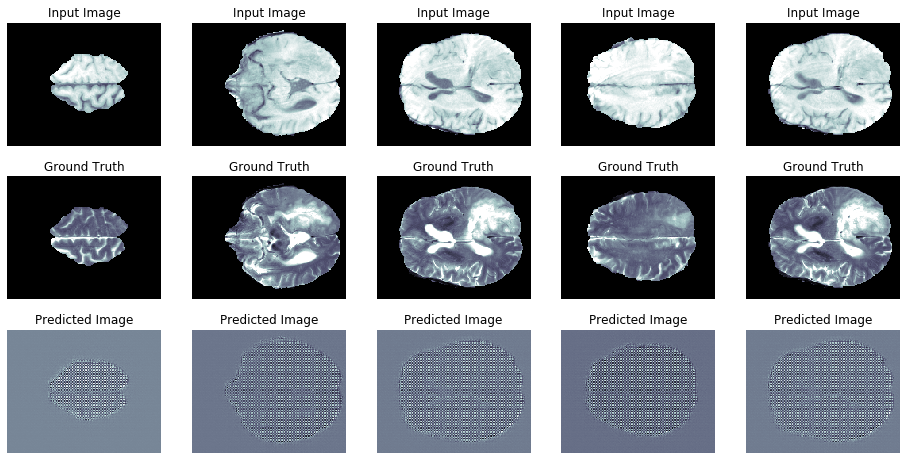


PSNR on validation set: 9.8051 ± 4.7480
PSNR norm on validation set: 7.4882 ± 0.6972

MSE on validation set: 0.1346 ± 0.0760
MSE norm on validation set: 0.1807 ± 0.0307

SSIM on validation set: 0.5309 ± 0.2099
SSIM norm on validation set: 0.0081 ± 0.0046

Epoch:  1
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................................................................................................
700

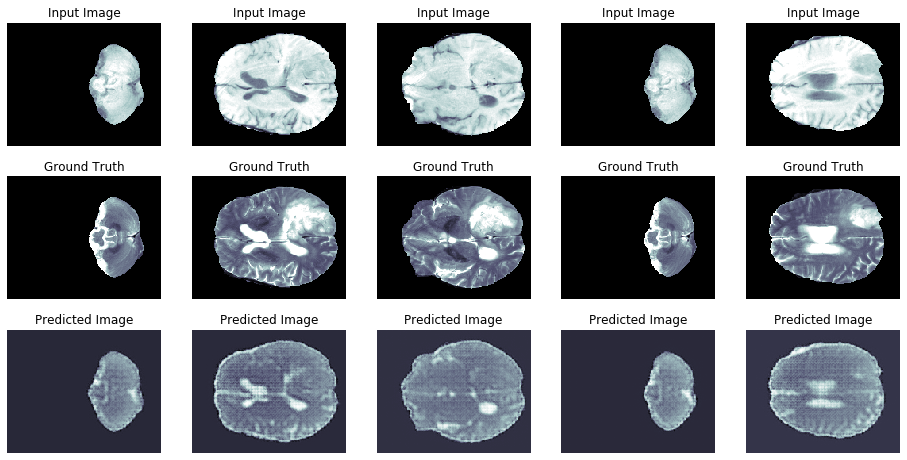


PSNR on validation set: 19.2877 ± 8.4651
PSNR norm on validation set: 14.3851 ± 1.6782

MSE on validation set: 0.0210 ± 0.0168
MSE norm on validation set: 0.0396 ± 0.0204

SSIM on validation set: 0.7304 ± 0.1291
SSIM norm on validation set: 0.1966 ± 0.0958

Time taken for epoch 1 is 428.99706768989563 sec


Epoch:  2
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
...................................................

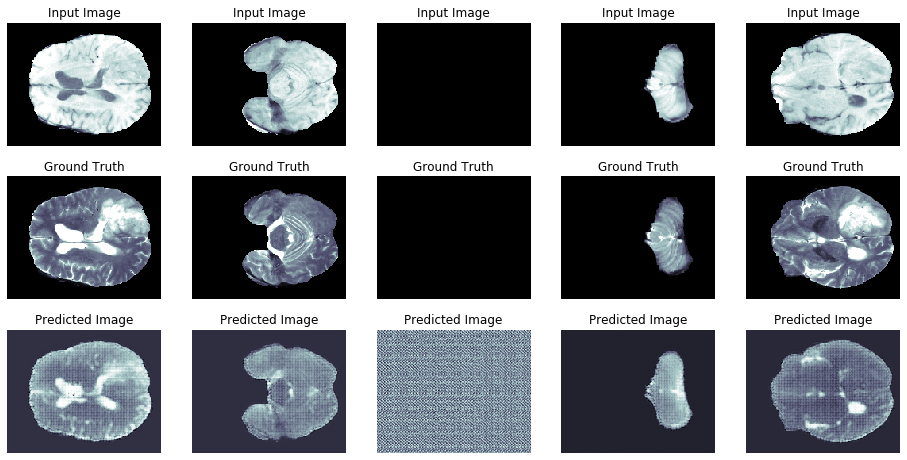


PSNR on validation set: 18.9831 ± 8.5905
PSNR norm on validation set: 14.1089 ± 2.2312

MSE on validation set: 0.0248 ± 0.0233
MSE norm on validation set: 0.0466 ± 0.0462

SSIM on validation set: 0.7177 ± 0.1454
SSIM norm on validation set: 0.1791 ± 0.0850

Time taken for epoch 2 is 421.239483833313 sec


Epoch:  3
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
.....................................................

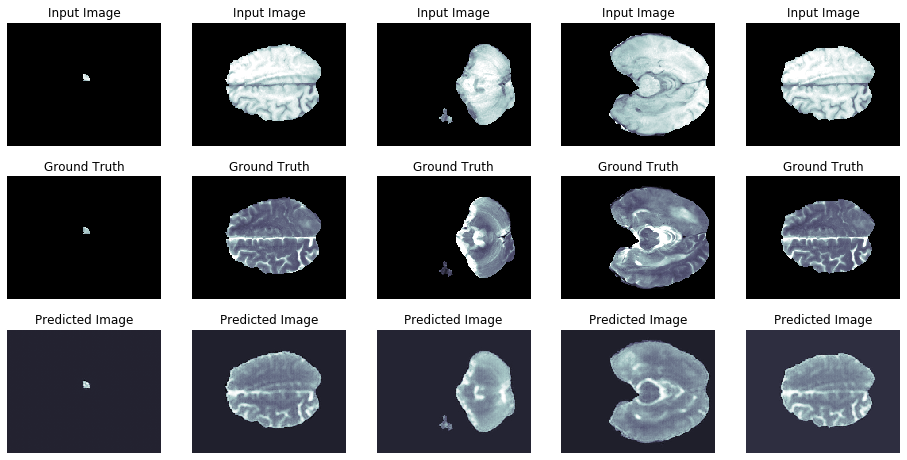


PSNR on validation set: 21.0305 ± 8.7842
PSNR norm on validation set: 15.3489 ± 3.1317

MSE on validation set: 0.0147 ± 0.0135
MSE norm on validation set: 0.0411 ± 0.0483

SSIM on validation set: 0.7983 ± 0.1057
SSIM norm on validation set: 0.2463 ± 0.1161

Time taken for epoch 3 is 420.8500266075134 sec


Epoch:  4
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................................................

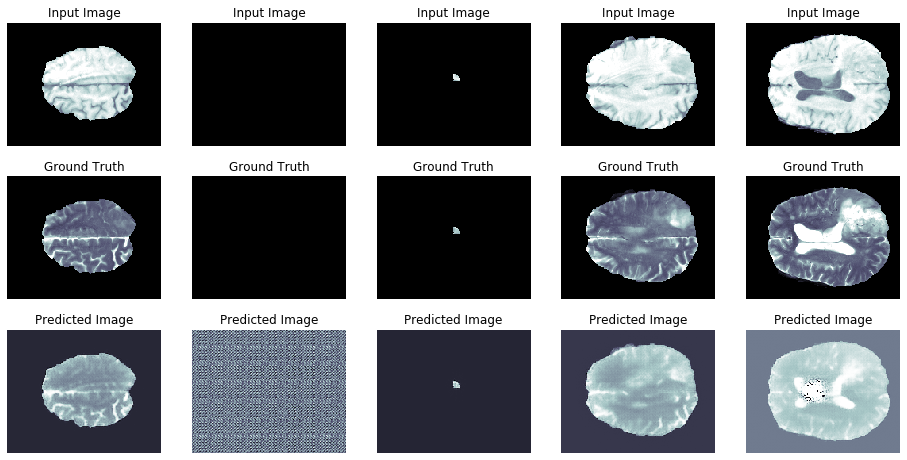


PSNR on validation set: 21.7182 ± 8.8656
PSNR norm on validation set: 14.9525 ± 3.6966

MSE on validation set: 0.0117 ± 0.0092
MSE norm on validation set: 0.0494 ± 0.0565

SSIM on validation set: 0.7968 ± 0.1037
SSIM norm on validation set: 0.2349 ± 0.1068

Time taken for epoch 4 is 421.01964569091797 sec



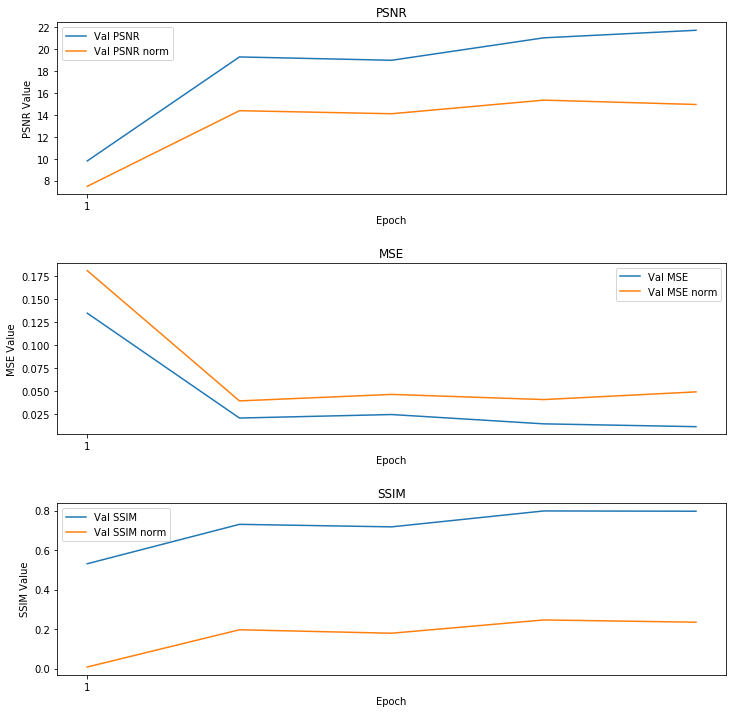

In [37]:
EPOCHS = 4
save_checkpoint = False         # if I want to train without saving checkpoints, then keep the value to False
save_final_models = False
epochs_already_trained = 0      # this is just for the print. 

# training, validation, testing = load_datasets() # I'll use this in case I get stuck with the cache.

# Initialize the models, so that I don't have to restart the runtime again.
psnr, mse, ssim, psnr_norm, mse_norm, ssim_norm = fit(training, EPOCHS, validation, save_checkpoint, epochs_already_trained)

plot_metrics(psnr, mse, ssim, psnr_norm, mse_norm, ssim_norm)

# at the end, I'll save the models (I would need only the gen, but let's sayve also the disc  )
# (it saves the entire model to a HDF5 file)

if save_final_models:
    generator.save('drive/My Drive/MRI-generation/gen_test2.h5')
    discriminator.save('drive/My Drive/MRI-generation/disc_test2.h5') 

##Evaluating the final model with the test set

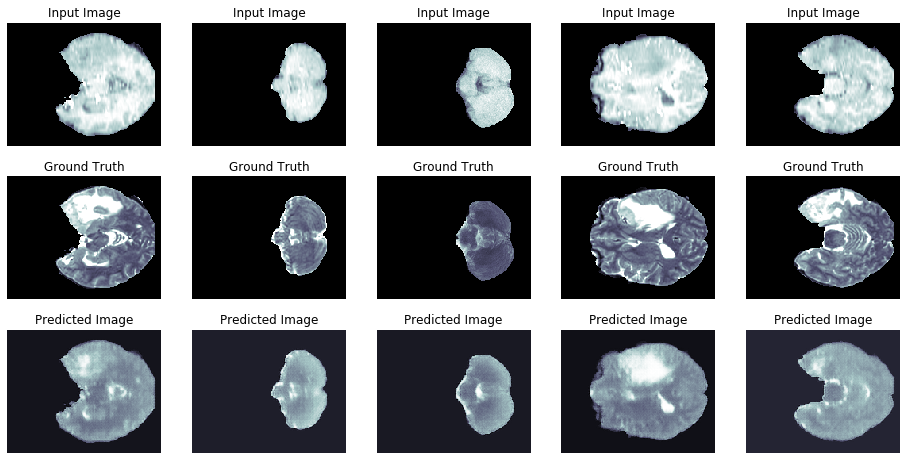


PSNR on test set: 14.6159 ± 3.4994
MSE on test set: 0.0505 ± 0.0523
SSIM on test set: 0.2295 ± 0.1009


(<tf.Tensor: id=2753879, shape=(), dtype=float32, numpy=14.615889>,
 <tf.Tensor: id=2753944, shape=(), dtype=float32, numpy=0.05048671>,
 <tf.Tensor: id=2754009, shape=(), dtype=float32, numpy=0.22952366>)

In [38]:
# Let's check the scores of this model.

evaluate_GAN(generator, testing, 'test')

## Additional notes

In [0]:
for raw_record in validation.take(1):
    inp, ground_truth = take_images_from_raw(raw_record)
    prediction = generator(inp, training=False)
    inp, ground_truth_cr, prediction = resize_with_crop(inp, ground_truth, prediction)
    plot_images(inp, ground_truth_cr, prediction)

    prediction_cr = normalize(prediction)

    mean, std, psnr = compute_psnr(ground_truth_cr, prediction_cr)
    print("PSNR: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std, ssim = compute_ssim(ground_truth_cr, prediction_cr)
    print("SSIM: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std, mse = compute_mse(ground_truth_cr, prediction_cr)
    print("MSE: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))


In [0]:
# in the testing there are 28 patients so 128*28 = 3584 samples
# with a batch_size of 32, we have 112 elements in the prefetched TEST set so 3584 samples.
# in the VALIDATION SET: 108 elements * 32 (batch_size) = 3456 samples.
# in the TRAINING set: 876 elements * 32 = 28032

# each samples has then all the scans defined in the load_dataset (up to 4 scans + the segmented area)
# if batch size is set to 32, then there are less then 100 samples.

# training: with GPU it crashes, with TPU works. a bit more of 28000 samples -> 219 patients * 128 levels.

# training with 100 samples, batch size = 1 and TPU took 46 seconds
# training with 100 samples, batch size = 1 and GPU took 7/8 seconds

# training with 1000 samples, batch size = 1, resizing to 256, GPU took 54 seconds
# training with 1000 samples, batch size = 1, padding to 256, GPU took 52 seconds

# TRAINING TIMES WITH DIFFERENT BATCH SIZES:
# training with 16 samples and batch size = 64 (so 1024 samples fed to the GAN), TPU took 209 seconds

# training with 1000 samples and batch size = 1 (so 1000 samples fed to the GAN), GPU took about 490 seconds (8 min)
# training with 250 samples and bs = 4 (so 1000 samples fed to the GAN), GPU took 127 seconds!
# training with 128 samples and bs = 8 (so 1024 samples fed to the GAN), GPU took 75 seconds!
# training with 64 samples and bs = 16 (so 1024 samples fed to the GAN), GPU took 41 seconds!
# training with 31 samples and bs = 32 (so still 992 samples fed to the GAN), GPU took 28/32/33
# training with 16 samples and bs = 64 (so 1024 samples fed to the GAN), GPU took 23/25/26 seconds!

# training with 8 samples and bs = 128, GPU took 24/25( 21 in the most recent) sec! -> not so good quality
# (It has been observed in practice that when using a larger batch there is a significant degradation in the 
# quality of the model, as measured by its ability to generalize.)
# https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network

# The resulting model may not generalize as well as a model trained with a small batch size

# tradeoff between 32 and 64. 32 seems to be qualitatively more accurate but it's a bit slower. 
# before choosing, it would be better to implement also the quantitative metrics.

# from pix2pix paper: use batch sizes between 1 and 10 depending on the experiment


# In general, batch size of 32 is a good starting point, and you should also try with 64, 128, and 256. 
# Other values (lower or higher) may be fine for some data sets, but the given range is generally the best to 
# start experimenting with. Though, under 32, it might get too slow because of significantly lower computational speed, 
# because of not exploiting vectorization to the full extent.  
# If you get an "out of memory" error, you should try reducing the mini-batch size anyway.


# training with 4 samples and bs = 256, GPU run out of memory. Resource exhausted.

In [0]:
# np.FUNCTION VS tf.FUNCTION

# np =  training with 31 samples and bs = 32 (992 samples fed to the GAN), GPU took 28/32/33
# training with 32 samples and bs = 32 (1024 samples fed to the GAN), GPU took 14/15/16/17 seconds 